Put some basic use cases for automated backtest/trading

In [107]:
import twsq
from twsq.alpha import Alpha
import pandas as pd
import numpy as np
import requests
import util

In [108]:
from twsq.utils import get_twsqroot
get_twsqroot()

C:\Users\joshu\Documents\TWSQ Library


'C:\\Users\\joshu\\Documents\\TWSQ Library'

In [117]:
layer1_coin_tickers = util.get_layer1_universe()

Fetched page 1 with 250 coins.
Fetched page 2 with 250 coins.
Fetched page 3 with 248 coins.


In [ ]:
# layer 1 channel breakout long short
class L1CBLS(Alpha):
    def filter_universe(self, universe, window_needed, freq='1h'):
        """
        Filter the provided universe to include only symbols for which data exists.

        Parameters:
        -----------
        universe : list
            List of asset symbols.
        window_needed : int
            Minimum number of bars required.
        freq : str, optional
            Frequency of the bars (default '1h').

        Returns:
        --------
        list
            Filtered list of symbols.
        """
        valid_symbols = []
        for symbol in universe:
            try:
                bars = self.get_lastn_bars(symbol + '/USD', n=window_needed, freq=freq)
                if not bars.empty and len(bars) >= window_needed:
                    valid_symbols.append(symbol)
            except Exception as e:
                continue
        return valid_symbols
    
    def prepare(self, universe=None, short_lookback=1, short_enter_lookback=1176, short_exit_lookback=36, dollar_exposure=1000):
        """
        Initialize strategy parameters.

        Parameters:
        -----------
        universe : list
            List of asset symbols to consider (e.g. ['BTC/USD', 'ETH/USD']).
        short_lookback : int, optional
            Lookback period for short-term high/low calculations.
        enter_lookback : int, optional
            Lookback period for the entry threshold.
        exit_lookback : int, optional
            Lookback period for the exit threshold.
        dollar_exposure : float, optional
            Total dollar exposure.
        """
        if universe is None:
            universe = util.get_layer1_universe()
        universe = [str(symbol).upper() for symbol in universe]
        self.short_lookback = short_lookback
        self.short_enter_lookback = short_enter_lookback
        self.short_exit_lookback = short_exit_lookback
        self.dollar_exposure = dollar_exposure
        window_needed = max(self.short_lookback, self.short_enter_lookback, self.short_exit_lookback)
        self.universe = self.filter_universe(universe, window_needed)
        # print("Using Layer 1 universe: ", universe)



        # Initialize each asset's signal to 0 (flat)
        self.current_signals = {symbol: 0 for symbol in universe}

    def rebalance(self):
        """
        Compute channel breakout signals and rebalance positions.
        Dollar exposure is total exposure across all short positions.
        """
        target = {}
        signals = {}
        # Determine the number of bars needed from history.
        window_needed = max(self.short_lookback, self.short_enter_lookback, self.short_exit_lookback)
        
        # Compute signals for each asset.
        for symbol in self.universe:
            try:
                bars = self.get_lastn_bars(symbol + "/USD", n=window_needed, freq='1h')
                # Check if we have enough data.
                if bars.empty or len(bars) < window_needed:
                    signal = self.current_signals.get(symbol, 0)
                else:
                    price_series = bars
                    # Compute rolling values.
                    short_max      = price_series['high'].iloc[-self.short_lookback:].max()
                    short_min      = price_series['low'].iloc[-self.short_lookback:].min()
                    short_enter_min = price_series['low'].iloc[-self.short_enter_lookback:].min()
                    short_exit_max = price_series['high'].iloc[-self.short_exit_lookback:].max()
                    
                    # Determine signal based on the most recent value.
                    if not price_series.empty:
                        if short_min == short_enter_min:
                            signal = -1  # Enter short
                        elif short_max == short_exit_max:
                            signal = 0   # Exit short
                        else:
                            signal = self.current_signals[symbol]
                    else:
                        signal = self.current_signals[symbol]
            except Exception as e:
                # In case of error, maintain the previous signal.
                signal = self.current_signals[symbol]
            
            self.current_signals[symbol] = signal
            signals[symbol] = signal
        # Count the number of symbols with a short signal (-1).
        shorts = [symbol for symbol, sig in signals.items() if sig == -1]
        n_shorts = len(shorts)
        
        # Compute target positions using total dollar exposure split across short positions.
        for symbol, signal in signals.items():
            try:
                price = self.get_current_price(symbol + '/USD')
            except Exception as e:
                print(f"Error fetching price for {symbol}: {e}")
                continue
            
            if signal == -1 and n_shorts > 0:
                # print(f"Shorting {symbol} at price {price}")
                # Allocate total exposure equally among all assets with a short signal.
                target[symbol] = - (self.dollar_exposure / n_shorts) / price
            else:
                target[symbol] = 0
            
        # Rebalance portfolio to target positions using TWSQ's built-in function.
        self.trade_to_target(target, quote='USD', route=True)

        


In [99]:
result = L1CBLS.run_backtest(start_ts='20250101', universe = layer1_coin_tickers)

Running L1CBLS backtest: 100.00% done | Total PnL (USDT): -1,155 | Duration (s): 38  

<Axes: xlabel='Date'>

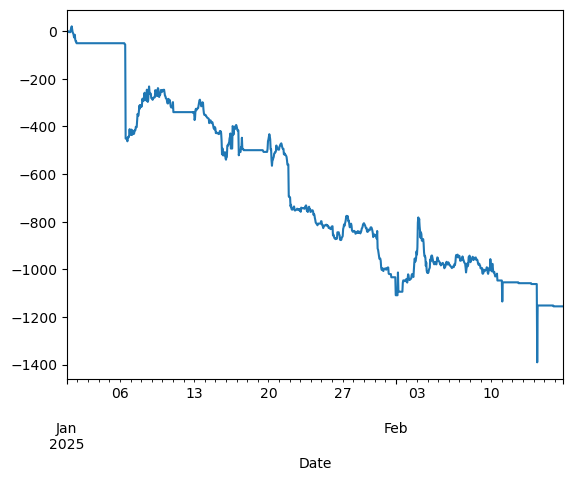

In [100]:
result.pos_pnl['port_val'].plot()

In [101]:
ret = result.pos_pnl['port_val']+1000
ret = ret.pct_change()
sharpe = np.sqrt(365*24) * ret.mean() / ret.std()
sharpe

-3.0927790038127405